## **Features**

A Jupyter notebook talking about features avaliable in PHOEBE, placing empthasis on the included Guassian Process feature. This roughly follows the given tutorial provided at https://phoebe-project.org/docs/2.4/.

### Setup

In [2]:
import phoebe as phb

In [3]:
logger = phb.logger()
bSystem = phb.default_binary()

### Available Features

PHOEBE has several inbuilt features, which can be viewed by using `phb.list_available_features`.

In [3]:
print(phb.list_available_features())

['gaussian_process', 'gp_celerite2', 'gp_sklearn', 'spot']


A feature can be added using `bSystem.add_feature`. Some features needs to be attached to a specific component. This can be checked using the `help()` function.

In [4]:
help(phb.feature.spot)

Help on function spot in module phoebe.parameters.feature:

spot(feature, **kwargs)
    Create a <phoebe.parameters.ParameterSet> for a spot feature.

    Generally, this will be used as an input to the kind argument in
    <phoebe.frontend.bundle.Bundle.add_feature>.  If attaching through
    <phoebe.frontend.bundle.Bundle.add_feature>, all `**kwargs` will be
    passed on to set the values as described in the arguments below.  Alternatively,
    see <phoebe.parameters.ParameterSet.set_value> to set/change the values
    after creating the Parameters.

    Allowed to attach to:
    * components with kind: star
    * datasets: not allowed

    Arguments
    ----------
    * `colat` (float/quantity, optional): colatitude of the center of the spot
        wrt spin axis.
    * `long` (float/quantity, optional): longitude of the center of the spot wrt
        spin axis.
    * `radius` (float/quantity, optional): angular radius of the spot.
    * `relteff` (float/quantity, optional): temper

In this example, the spot feature can be attached to a star, but not to a dataset.

In [6]:
help(phb.feature.gp_celerite2)

Help on function gp_celerite2 in module phoebe.parameters.feature:

gp_celerite2(feature, **kwargs)
    Create a <phoebe.parameters.ParameterSet> for a gp_celerite2 feature.

    Requires celerite2 to be installed.  See https://celerite2.readthedocs.io/en/stable/.
    If using gaussian processes, consider citing:
    * https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F

    See also:
    * <phoebe.frontend.bundle.Bundle.references>

    Generally, this will be used as an input to the kind argument in
    <phoebe.frontend.bundle.Bundle.add_feature>.  If attaching through
    <phoebe.frontend.bundle.Bundle.add_feature>, all `**kwargs` will be
    passed on to set the values as described in the arguments below.  Alternatively,
    see <phoebe.parameters.ParameterSet.set_value> to set/change the values
    after creating the Parameters.

    Allowed to attach to:
    * components: not allowed
    * datasets with kind: lc

    If `compute_times` or `compute_phases` is used: the underlyin

In this example, the celerite2 Guassian Process (a machine learning technique) can be attached to light curves only.

## Gaussian Process Regression

*Note: This section is probably not needed in using PHOEBE, but I found the topic interesting since I want to know a bit more about Machine Learning.*

### PHOEBE's Implementation

We are aiming to reproduce Figure 7 from PHOEBE's fitting release paper ([Conroy et al. 2020](https://phoebe-project.org/publications/2020Conroy+)).

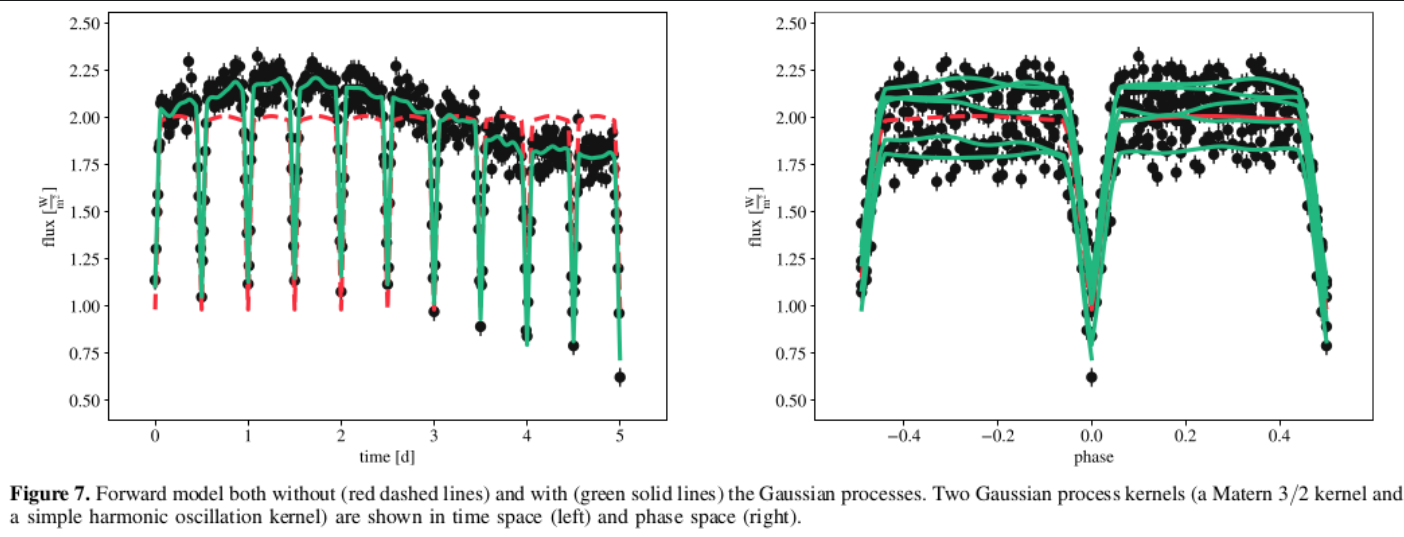

Let us quickly set everything up in redards to plotting, error logging and also setting a set seed to ensure reproducibility.

In [23]:
import matplotlib.pyplot as plt

# Plotting customisation
plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

# Logger setup
logger = phb.logger('warning')

# Seed setup
import numpy as np
np.random.seed(123456789)

Now we'll generate the fake observations.

In [24]:
bSystem = phb.default_binary()
bSystem.add_dataset(
    'lc',
    compute_times=phb.linspace(0,5,501)
)
bSystem.run_compute()

times = bSystem['times@model'].get_value()
fluxes = bSystem['fluxes@model'].get_value() + np.random.normal(size=times.shape) * 0.07 + 0.2*np.sin(times)
sigmas = np.ones_like(fluxes) * .05

100%|██████████| 501/501 [00:03<00:00, 150.06it/s]


And now compute our system without using the Gaussian Process.

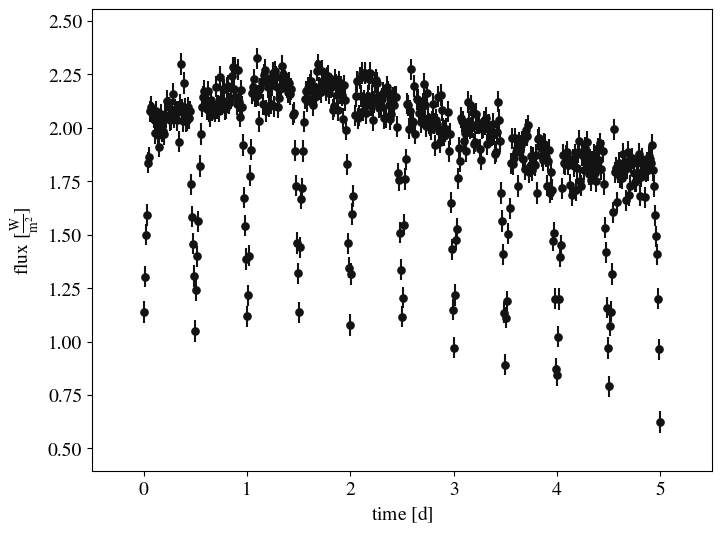

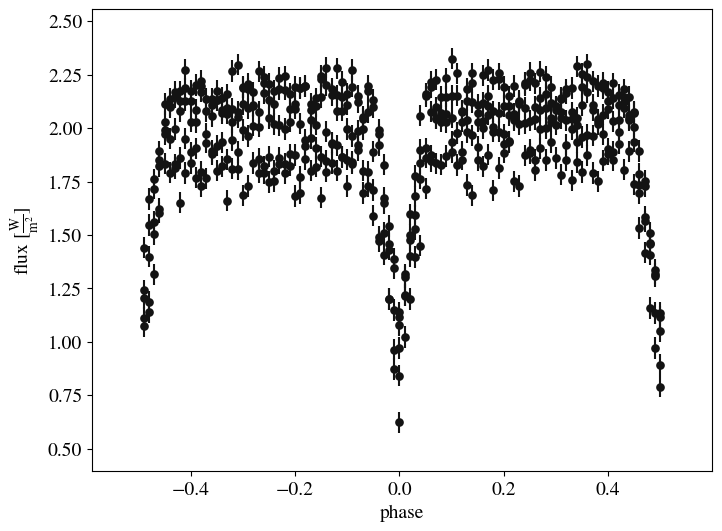

100%|██████████| 501/501 [00:03<00:00, 148.81it/s]


<ParameterSet: 3 parameters | qualifiers: fluxes, comments, times>

In [25]:
bSystem = phb.default_binary()
bSystem.add_dataset(
    'lc',
    times=times,
    fluxes=fluxes,
    sigmas=sigmas,
    dataset='lc01'
)

bSystem['lc01'].plot(show=True, s=0.01)
bSystem['lc01'].plot(x='phases',show=True, s=0.01)

bSystem.run_compute(model='noGP')

Now let us add the Gaussian Process. We need to specify a Kernel for it to run, this example uses `matern32`, but `sho` and `rotation` are also valid choices.

In [26]:
# Uncomment the line below to install Celerite2
#!pip install -U celerite2

bSystem.add_gaussian_process(
    kind='celerite2', # What implementation of Guassian Process to use, either 'celerite2' or 'sklearn'
    dataset='lc01',
    kernel='matern32'
)

<ParameterSet: 11 parameters | contexts: compute, feature>

As this system is time-independent (i.e. each complete cycle will be the same), the model is only computed for one cycle according to `compute_phases`. From this, it can be interpolated at the phases of the times in the dataset to compute the fluxes + gaussian processes.

If the system was time-dependent, a sufficient time-span needs to be covered or else PHOEBE will throw an error.

This can be roughly checked by using `bSystem.get_hierarchy().is_time_dependent` **BEFORE** you add a GP.

In [27]:
print(bSystem.run_checks_compute())

Run Checks Report: PASS



In [28]:
bSystem.flip_constraint('compute_phases', solve_for='compute_times')
bSystem['compute_phases'] = phb.linspace(0, 1, 101) # Reduce the number of times for compute_phases. This could cause an issue if the system is time dependent, but it is not a problem here.

print(bSystem.run_checks_compute())

Run Checks Report: WARNING


In [29]:
bSystem.run_compute(model='withGP')

Fri, 18 Jul 2025 18:25 BUNDLE       WARNING underlying model will be computed at compute_times for lc01 but exposed at dataset times in order to include gaussian processes
100%|██████████| 101/101 [00:00<00:00, 144.99it/s]
Fri, 18 Jul 2025 18:25 BUNDLE       WARNING model for dataset='lc01' resampled at dataset times when adding GPs


<ParameterSet: 5 parameters | qualifiers: fluxes_nogps, times, fluxes, comments, gps>

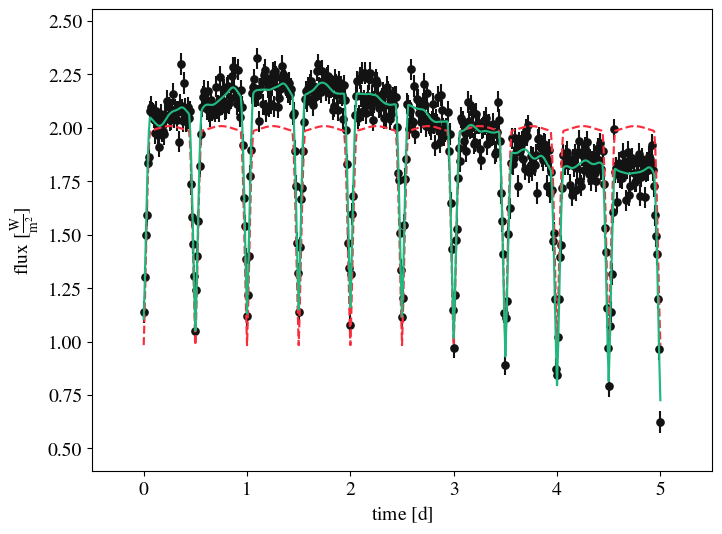

Fri, 18 Jul 2025 18:27 PARAMETERS   WARNING defaulting to i='times' to plot in time-order because system is time_dependent.  Pass i='phases' to override.
Fri, 18 Jul 2025 18:27 PARAMETERS   WARNING defaulting to i='times' to plot in time-order because system is time_dependent.  Pass i='phases' to override.
Fri, 18 Jul 2025 18:27 PARAMETERS   WARNING defaulting to i='times' to plot in time-order because system is time_dependent.  Pass i='phases' to override.


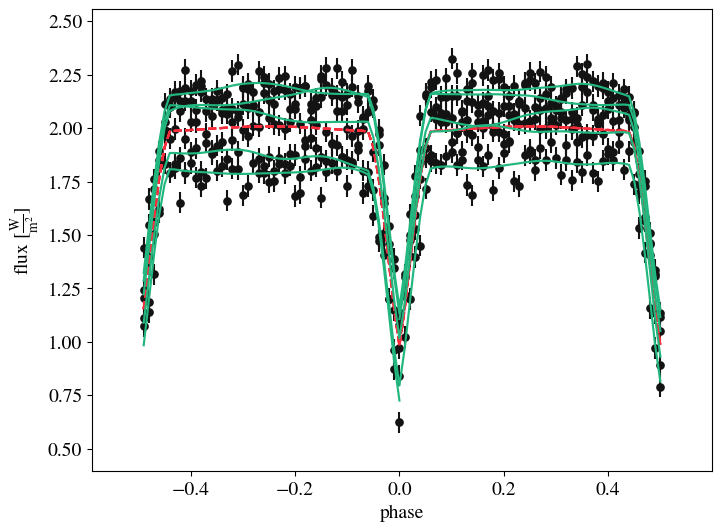

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [34]:
bSystem.plot(
    c = {'noGP' : 'red', 'withGP' : 'green'},
    ls = {'noGP' : '--', 'withGP' : '-'},
    s = {'model' : 0.01, 'dataset' : 0.01},
    show=True
)

bSystem.plot(
    c = {'noGP' : 'red', 'withGP' : 'green'},
    ls = {'noGP' : '--', 'withGP' : '-'},
    s = {'model' : 0.01, 'dataset' : 0.01},
    x='phases',
    show=True
)

So we can see that our Gaussian Process has successfully fitted to our 'observational' data. 